In [39]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier 
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, precision_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline

import category_encoders as ce

In [40]:
master_df = pd.read_csv('FINAL3.csv')

In [41]:
# master_df = master_df[['Make','Year','Model','Service Category','Work Order']]

master_df = master_df[['Work Order','Make','Year','Model','Service Category','Mileage In']]

In [42]:
master_df = master_df.drop_duplicates()

In [43]:
master_df['Year'].value_counts()

2014    1059
2015     946
2016     816
2013     692
2017     677
2010     550
2011     538
2012     509
2008     380
2018     319
2009     272
2005     235
2007     204
2006     195
2004     149
2019     145
2003     111
2002     105
2000      69
2020      62
1997      45
2001      34
1996      25
1998      24
1995      23
1999      20
1994      11
1992      10
1987       7
1991       6
2021       3
1969       3
1993       2
1973       2
1990       1
1989       1
Name: Year, dtype: int64

In [44]:
# car year

year_list = master_df['Year'].value_counts().to_frame()
year_list = year_list[year_list['Year'] <= 100]
year_list = list(year_list.index)

master_df = master_df[~master_df['Year'].isin(year_list)]

In [45]:
# checking the number of unique transaction per Year

master_df['Year'].value_counts()

2014    1059
2015     946
2016     816
2013     692
2017     677
2010     550
2011     538
2012     509
2008     380
2018     319
2009     272
2005     235
2007     204
2006     195
2004     149
2019     145
2003     111
2002     105
Name: Year, dtype: int64

In [46]:
# Removing the exhaust, counter / cash sale, sublet & towing and car detailing services

master_df = master_df[(master_df['Service Category'] != 'Exhaust') &
                      (master_df['Service Category'] != 'Counter / Cash Sale') &
                      (master_df['Service Category'] != 'Sublet & Towing') &
                      (master_df['Service Category'] != 'Car Detailing Services')]

# filtering the accessories category

master_df = master_df[master_df['Service Category'] != 'Accessories (Gauges, Power Accessories, Vision & Air Bag)']
master_df = master_df[master_df['Service Category'] != 'Drive Train (Final Drive, Transaxle, Differential & Transfer Case)']

In [47]:
# checking the number of unique transaction per Service Category

master_df['Service Category'].value_counts()

Oil, Lube & Preventive Maintenance Service                   3746
Steering & Suspension                                         947
Brakes                                                        518
Driveability (Fuel, Ignition & Emission Systems)              359
Engine                                                        300
Electrical (Belts, Lighting, Starting & Charging Systems)     298
Tires & Wheels                                                284
HVAC (Heating, Ventilation & Air Conditioning)                283
Transmission & Clutch                                         263
Cooling System                                                230
Batteries                                                     140
Name: Service Category, dtype: int64

In [48]:
# car make

car_list = master_df['Make'].value_counts().to_frame()
car_list = car_list[car_list['Make'] <= 100]
car_list = list(car_list.index)

master_df = master_df[~master_df['Make'].isin(car_list)]

In [49]:
# checking the number of unique transaction per car make

master_df['Make'].value_counts()

toyota        2657
mitsubishi    1141
honda          848
ford           815
hyundai        671
nissan         245
chevrolet      212
isuzu          195
mazda          169
suzuki         141
kia            105
Name: Make, dtype: int64

In [50]:
# Balancing the dataset

oipms = master_df[master_df['Service Category'] == 'Oil, Lube & Preventive Maintenance Service'].sample(n = 3800, replace = True, random_state = 4244)
steer_sus = master_df[master_df['Service Category'] == 'Steering & Suspension'].sample(n = 3800, replace = True, random_state = 4244)
brakes = master_df[master_df['Service Category'] == 'Brakes'].sample(n = 3800, replace = True, random_state = 4244)
driveability = master_df[master_df['Service Category'] == 'Driveability (Fuel, Ignition & Emission Systems)'].sample(n = 3800, replace = True, random_state = 4244)
engine = master_df[master_df['Service Category'] == 'Engine'].sample(n = 3800, replace = True, random_state = 4244)
electrical = master_df[master_df['Service Category'] == 'Electrical (Belts, Lighting, Starting & Charging Systems)'].sample(n = 3800, replace = True, random_state = 4244)
tires_wheels = master_df[master_df['Service Category'] == 'Tires & Wheels'].sample(n = 3800, replace = True, random_state = 4244)
hvac =  master_df[master_df['Service Category'] == 'HVAC (Heating, Ventilation & Air Conditioning)'].sample(n = 3800, replace = True, random_state = 4244)
trans_clutch = master_df[master_df['Service Category'] == 'Transmission & Clutch'].sample(n = 3800, replace = True, random_state = 4244)
cooling = master_df[master_df['Service Category'] == 'Cooling System'].sample(n = 3800, replace = True, random_state = 4244)
battery = master_df[master_df['Service Category'] == 'Batteries'].sample(n = 3800, replace = True, random_state = 4244)


In [51]:
master_df = pd.concat([oipms, steer_sus, brakes, driveability, engine, electrical, tires_wheels, hvac, trans_clutch, cooling, battery])
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41800 entries, 20201 to 2651
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Work Order        41800 non-null  int64 
 1   Make              41800 non-null  object
 2   Year              41800 non-null  int64 
 3   Model             41800 non-null  object
 4   Service Category  41800 non-null  object
 5   Mileage In        41800 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 2.2+ MB


In [52]:
# optional bucketing the Mileage In

def mileage_func(x):
    if x <= 10000:
        return '10k'
    if 10001 <= x <= 20000:
        return '20k'
    if 20001 <= x <= 30000:
        return '30k'
    if 30001 <= x <= 40000:
        return '40k'
    if 40001 <= x <= 50000:
        return '50k'
    if 50001 <= x <= 60000:
        return '60k'
    if 60001 <= x <= 70000:
        return '70k'
    if 70001 <= x <= 80000:
        return '80k'
    if 80001 <= x <= 90000:
        return '90k'
    if 90001 <= x <= 100000:
        return '100k'
    if 100001 <= x <= 150000:
        return '150k'
    if 150001 <= x <= 200000:
        return '200k'
    else:
        return 'above 200k'

In [53]:
master_df['Mileage In_'] = master_df['Mileage In'].apply(mileage_func)

In [54]:
master_df['Service Category'].value_counts()

Brakes                                                       3800
Oil, Lube & Preventive Maintenance Service                   3800
Transmission & Clutch                                        3800
Cooling System                                               3800
Electrical (Belts, Lighting, Starting & Charging Systems)    3800
Engine                                                       3800
Steering & Suspension                                        3800
HVAC (Heating, Ventilation & Air Conditioning)               3800
Driveability (Fuel, Ignition & Emission Systems)             3800
Tires & Wheels                                               3800
Batteries                                                    3800
Name: Service Category, dtype: int64

In [55]:
# Encoding the dataset

master_df = master_df[['Make','Year','Model','Service Category','Mileage In_']]

In [56]:
X = master_df[['Year', 'Make', 'Model','Mileage In_']]
Y = master_df['Service Category']

In [57]:
encoder = ce.BinaryEncoder(cols=['Year', 'Make', 'Model','Mileage In_'], return_df = True)
encoder.fit(X)

BinaryEncoder(cols=['Year', 'Make', 'Model', 'Mileage In_'])

In [58]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 4244, test_size = 0.20, stratify = Y)

In [59]:
X_train_encoded = encoder.transform(x_train)
X_test_encoded = encoder.transform(x_test)

print(X_train_encoded.shape, X_test_encoded.shape)

(33440, 25) (8360, 25)


In [61]:
model_ = RandomForestClassifier(bootstrap = True, criterion = 'entropy', max_depth =25, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 150, random_state = 4244)

In [62]:
model_.fit(X_train_encoded, y_train)

RandomForestClassifier(criterion='entropy', max_depth=25, n_estimators=150,
                       random_state=4244)

In [63]:
y_pred = model_.predict(X_test_encoded)

In [64]:
print("Precision score: {:.3f}".format(precision_score(y_test,y_pred , average='macro')))
print("Accuracy Score:{:.3f}".format(accuracy_score(y_test, y_pred)))
print("Classification Report: \n", classification_report(y_test, y_pred))

Precision score: 0.545
Accuracy Score:0.516
Classification Report: 
                                                            precision    recall  f1-score   support

                                                Batteries       0.46      0.83      0.60       760
                                                   Brakes       0.56      0.43      0.49       760
                                           Cooling System       0.47      0.62      0.54       760
         Driveability (Fuel, Ignition & Emission Systems)       0.59      0.47      0.52       760
Electrical (Belts, Lighting, Starting & Charging Systems)       0.52      0.54      0.53       760
                                                   Engine       0.45      0.59      0.51       760
           HVAC (Heating, Ventilation & Air Conditioning)       0.48      0.55      0.51       760
               Oil, Lube & Preventive Maintenance Service       0.76      0.26      0.39       760
                                    Ste

<Figure size 1080x1080 with 0 Axes>

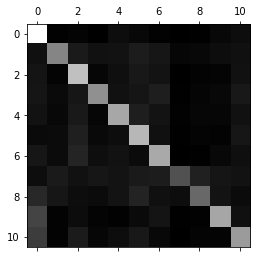

In [65]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15,15))
plt.matshow(conf_matrix, cmap = plt.cm.gray)

In [66]:
# Using the AdaboostClassifier
model_ = RandomForestClassifier(bootstrap = True, criterion = 'entropy', max_depth =25, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 150, random_state = 4244)

In [67]:
abc_model = AdaBoostClassifier(base_estimator = model_, random_state = 4244, learning_rate = 0.1)

In [68]:
abc_model.fit(X_train_encoded, y_train)

AdaBoostClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                         max_depth=25,
                                                         n_estimators=150,
                                                         random_state=4244),
                   learning_rate=0.1, random_state=4244)

In [69]:
y_pred = abc_model.predict(X_test_encoded)

In [70]:
print("Precision score: {:.3f}".format(precision_score(y_test,y_pred , average='macro')))
print("Accuracy Score:{:.3f}".format(accuracy_score(y_test, y_pred)))
print("Classification Report: \n", classification_report(y_test, y_pred))

Precision score: 0.527
Accuracy Score:0.511
Classification Report: 
                                                            precision    recall  f1-score   support

                                                Batteries       0.47      0.83      0.60       760
                                                   Brakes       0.56      0.40      0.47       760
                                           Cooling System       0.47      0.62      0.54       760
         Driveability (Fuel, Ignition & Emission Systems)       0.59      0.46      0.52       760
Electrical (Belts, Lighting, Starting & Charging Systems)       0.50      0.51      0.50       760
                                                   Engine       0.46      0.57      0.51       760
           HVAC (Heating, Ventilation & Air Conditioning)       0.49      0.54      0.51       760
               Oil, Lube & Preventive Maintenance Service       0.56      0.33      0.42       760
                                    Ste

<Figure size 1080x1080 with 0 Axes>

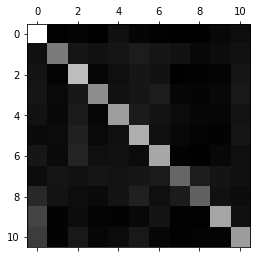

In [71]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15,15))
plt.matshow(conf_matrix, cmap = plt.cm.gray)

In [72]:
# OneVsOneClassifier 

In [73]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

In [74]:
clf = OneVsOneClassifier(model_, n_jobs = 4).fit(X_train_encoded, y_train)

In [75]:
y_pred = clf.predict(X_test_encoded)

In [76]:
print("Precision score: {:.3f}".format(precision_score(y_test,y_pred , average='macro')))
print("Accuracy Score:{:.3f}".format(accuracy_score(y_test, y_pred)))
print("Classification Report: \n", classification_report(y_test, y_pred))

Precision score: 0.542
Accuracy Score:0.514
Classification Report: 
                                                            precision    recall  f1-score   support

                                                Batteries       0.46      0.84      0.60       760
                                                   Brakes       0.57      0.42      0.48       760
                                           Cooling System       0.47      0.62      0.53       760
         Driveability (Fuel, Ignition & Emission Systems)       0.58      0.46      0.51       760
Electrical (Belts, Lighting, Starting & Charging Systems)       0.54      0.53      0.53       760
                                                   Engine       0.45      0.57      0.50       760
           HVAC (Heating, Ventilation & Air Conditioning)       0.48      0.55      0.51       760
               Oil, Lube & Preventive Maintenance Service       0.75      0.27      0.40       760
                                    Ste

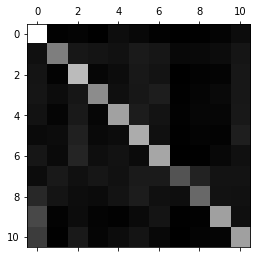

In [77]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.matshow(conf_matrix, cmap = plt.cm.gray)